In [141]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [142]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
#plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [143]:
#load data
dataName="_mainExpAvDurEstimate_2025-03-27_15h13.32.171.csv"
#"_visualDurEstimate_2025-03-12_20h35.26.573.csv"

data = pd.read_csv("dataAvMain/"+dataName)
data[:4]
data['avgAVDeltaS'] = (data['deltaDurS'] + (data['recordedDurVisualTest'] - data['recordedDurVisualStandard'])) / 2
# Calculate deltaDurPercentVisual just as the difference between the test and standard visual durations over the standard visual duration
data['deltaDurPercentVisual'] = ((data['recordedDurVisualTest'] - data['recordedDurVisualStandard']) / data['recordedDurVisualStandard'] 
)

data['avgAVDeltaPercent'] = data[['delta_dur_percents', 'deltaDurPercentVisual']].mean(axis=1)
data

,Unnamed: 0,standardDur,riseDur,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,recordedOnsetVisualTest,recordedOffsetVisualTest,recordedDurVisualTest,recordedOnsetVisualStandard,recordedOffsetVisualStandard,recordedDurVisualStandard,modalityPostCue,avgAVDeltaS,deltaDurPercentVisual,avgAVDeltaPercent
0,0,0.4997,1.1993,2,0.4831,0.5414,0.5580,0,2.2071,-0.750,...,1.6528,1.7278,0.0750,0.4112,1.0527,0.6415,A,-0.47065,-0.883087,-0.816543
1,1,0.4997,0.0999,2,0.5414,0.4581,0.7163,1,2.3154,-0.800,...,1.8704,1.9204,0.0500,0.4703,1.1118,0.6415,A,-0.49565,-0.922058,-0.861029
2,2,0.4997,1.1993,1,0.6496,0.4498,0.6413,2,3.1149,0.750,...,0.6087,1.5748,0.9660,2.1745,2.7660,0.5915,V,0.37465,0.633136,0.691568
3,3,0.4997,0.0999,2,0.4914,0.5664,0.5664,3,3.0234,0.800,...,1.6694,2.5191,0.8497,0.4193,1.0612,0.6419,V,0.30380,0.323726,0.561863
4,4,0.4997,1.1993,1,0.5664,0.5997,0.6830,4,2.4737,-0.750,...,0.5227,0.7395,0.2168,1.3564,1.9980,0.6417,A,-0.39985,-0.662147,-0.706074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,356,0.4997,1.1993,1,0.6163,0.5997,0.8162,356,3.4064,0.756,...,0.5708,1.5375,0.9667,2.3125,2.9041,0.5916,V,0.37495,0.634043,0.695022
357,357,0.4997,0.0999,2,0.5997,0.5247,0.7496,357,2.6902,-0.372,...,1.9661,2.2323,0.2662,0.5326,1.1743,0.6416,A,-0.27930,-0.585100,-0.478550
358,358,0.4997,0.0999,2,0.6080,0.4414,0.6413,358,2.9900,0.594,...,1.8655,2.6158,0.7503,0.5406,1.1825,0.6418,A,0.20415,0.169056,0.381528
359,359,0.4997,1.1993,1,0.5830,0.5330,0.8246,359,3.3398,0.800,...,0.5388,1.5300,0.9913,2.3133,2.9052,0.5918,V,0.39965,0.675059,0.737530


In [144]:
intensityVariable="avgAVDeltaPercent"

In [145]:
from scipy.stats import norm
from scipy.optimize import minimize

# Define Psychometric Function and Optimization

In [146]:

def psychometric_function(intensities, lapse_rate, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 

def derivative_psychometric_function(intensities, lapse_rate, mu, sigma):
    #F'(x) = (1-lambda)*(1(/sqrt(2*pi)sigma)exp((x-mu)^2/sigma^2)

    return (1 - lapse_rate) * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((intensities - mu) ** 2) / (2 * sigma ** 2))    

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, totalResp, fixedLapse=None,fixedSigma=None):
    if fixedLapse== None and fixedSigma== None:
        lambda_, mu, sigma = params # Unpack parameters
    elif  fixedLapse is not None and fixedSigma== None:
        lambda_ = fixedLapse
        mu, sigma = params
    elif fixedSigma != None and fixedLapse != None:
        mu=params
        sigma = fixedSigma
        lambda_=fixedLapse
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating the log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (totalResp - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(levels,nResp, totalResp,init_guesses=[0,0,0], fixedLapse=None,fixedSigma=None):
    # then fits the psychometric function
    # order is lambda mu sigma
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.02, 1)]  # Reasonable bounds
    if fixedLapse is not None and fixedSigma is not None:
        # If both lapse rate and sigma are fixed, we only optimize mu
        bounds = [(-0.4, +0.4)]  # Only mu is optimized
        init_guesses = [init_guesses[1]]  # Start with the initial guess for mu
    elif fixedLapse!= None and fixedSigma== None:
        # If only lapse rate is fixed, we optimize mu and sigma
        bounds = [ (-0.4, +0.4), (0.02, 1)]  # Lapse rate fixed, optimize mu and sigma
        init_guesses = init_guesses[1:]  # Start with the initial guesses for mu and sigma
    elif fixedSigma!= None and fixedLapse== None:
        # If only sigma is fixed, we optimize lambda and mu
        bounds = [(0, 0.2), (-0.4, +0.4)]  # Lapse rate and mu are optimized
        init_guesses = [init_guesses[0], init_guesses[1]]  # Start with the initial guesses for lambda and mu
    elif fixedLapse==None and fixedSigma==None:
        # If neither lapse rate nor sigma is fixed, we optimize all three parameters
        init_guesses = init_guesses  # Start with the initial guesses for all three parameters


  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(levels, nResp, totalResp,fixedLapse, fixedSigma),  # Pass the data and fixed parameters
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x

# Compute sigma from slope
def compute_sigma_from_slope(slope, lapse_rate=0.02):
    sigma = (1 - lapse_rate) / (np.sqrt(2 * np.pi) * slope)*np.exp(-0.5)
    return sigma


#  Raw psychometric

In [147]:
def rawNegLogLike(params, level, response):
    # Unpack parameters
    lapse_rate, mu, sigma = params
    # Compute the probability of choosing test
    p = psychometric_function(level, lapse_rate, mu, sigma)
    # Add a small number to avoid log(0)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(response * np.log(p) + (1 - response) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fitPsychometricRaw(levels, response,init_guesses=[0,0,0]):
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.05, 1)]  # Reasonable bounds
  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        rawNegLogLike, x0=init_guesses, 
        args=(levels, response),
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x


# Group data

In [148]:
# Define columns for chosing test or standard
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)
try:
    print(data["riseDur"]>1)
except:
    data["riseDur"]=1

data['standard_dur']=data['standardDur']

def groupByChooseTest(x):
    grouped = x.groupby([intensityVariable, 'riseDur', 'standard_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum')
    ).reset_index()
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

    return grouped

def groupByStandardDur(x):
    grouped = x.groupby([intensityVariable, 'riseDur', 'standard_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum')
    ).reset_index()
    grouped['pChooseStandard'] = grouped['num_of_chose_standard'] / grouped['total_responses']

    return grouped

grouped=groupByChooseTest(data)
# p_choose_test
#sort the group
grouped = grouped.sort_values([ 'standard_dur'])

0       True
1      False
2       True
3      False
4       True
       ...  
356     True
357    False
358    False
359     True
360    False
Name: riseDur, Length: 361, dtype: bool


# Estimate initial parameters

In [149]:
from scipy.stats import linregress
def estimate_initial_guesses(levels,chooseTest,totalResp, max_sigma_ratio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    intensities = levels
    chose_test = chooseTest
    total_resp = totalResp
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(intensities)) - np.abs(min(intensities))
    max_sigma = intensity_range * max_sigma_ratio
    #sigma_guess = min(sigma_guess, max_sigma)
    #sigma_guess=sigma_guess/3
    
    return [lapse_rate_guess, mu_guess, sigma_guess]
estimate_initial_guesses(grouped[intensityVariable],grouped['num_of_chose_test'],grouped['total_responses'])


def multipleStartsFit(levels, responses, n_starts=10, init_guesses=[0,0,0], fixedLapse=None,fixedSigma=None):
    """
    Fit the psychometric function with multiple random starts to avoid local minima.
    """
    best_fit = None
    best_neg_log_likelihood = float('inf')

    for _ in range(n_starts):
        # Generate random initial guesses
        if fixedLapse is not None and fixedSigma is not None:
            init_guess = [init_guesses[1]]  # Only optimize mu
        else:
            #init_guess = np.random.uniform(low=[0, -0.4, 0.05], high=[0.2, 0.4, 1], size=3)  # Random guesses for [lambda, mu, sigma]
            init_guess.append(np.random.uniform(0,0.2))  # Random guess for lambda
        # Fit the psychometric function
        try:
            fit_params = fit_psychometric_function(levels, responses, n_starts, init_guess, fixedLapse, fixedSigma)
            neg_log_likelihood = negative_log_likelihood(fit_params, levels, responses, len(responses), fixedLapse, fixedSigma)

            # Check if this fit is better than the previous best
            if neg_log_likelihood < best_neg_log_likelihood:
                best_fit = fit_params
                best_neg_log_likelihood = neg_log_likelihood
        except Exception as e:
            print(f"Error during fitting: {e}")
            continue

    return best_fit

def estimateInitialGuessesRaw(levels,responses,maxSigmaRatio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    # Compute proportion of "chose test"
    proportions = responses / levels
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(levels, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(levels)) - np.abs(min(levels))
    max_sigma = intensity_range * maxSigmaRatio
    sigma_guess = min(sigma_guess, max_sigma)
    #sigma_guess=sigma_guess/3
    
    return [lapse_rate_guess, mu_guess, sigma_guess]


# 1 by 1 Psychometric Function fitting

In [150]:
conflictLeves=sorted(data['conflictDur'].unique())
standardDurLevels=sorted(data['standardDur'].unique())
noiseLevels=sorted(data['riseDur'].unique())
print(f"Standard duration levels: {standardDurLevels}, Conflict levels: {conflictLeves}, Noise levels: {noiseLevels}")

Standard duration levels: [0.4997], Conflict levels: [-0.05, 0.0, 0.05], Noise levels: [0.0999, 1.1993]


In [151]:
# for i, standardLevel in enumerate(standardDurLevels):
#     for j, noiseLevel in enumerate(noiseLevels):
#         for k, conflictLevel in enumerate(conflictLeves):        
#             #filter data
#             df=data[data['conflictDur']==conflictLevel]
#             df= df[df["standardDur"]==standardLevel]
#             df=df[df["riseDur"]==noiseLevel]

#             # select levels
#             levels=df['avgAVDelta'].values
#             responses=df['chose_test'].values
#             # estimate initial guesses
#             initial_guesses = estimateInitialGuessesRaw(levels, responses)
               
#             # fit psychometric function
#             fitted_params = fitPsychometricRaw(levels, responses,initial_guesses)
#             # print fitted parameters
#             print(f"Standard duration: {standardLevel}, Noise level: {noiseLevel}, Conflict level: {conflictLevel}, Fitted parameters: {fitted_params}")

#             # plot psychometric function
#             plt.figure()
#             plt.scatter(levels, responses, label='Data', color='blue')
#             x = np.linspace(-0.9, 0.9, 100)
#             y = psychometric_function(x, *fitted_params)
#             plt.plot(x, y, label='Psychometric Function', color='red')
#             plt.axvline(x=0, color='gray', linestyle='--',)
#             plt.axhline(y=0.5, color='gray', linestyle='--')
#             plt.xlabel('Delta Duration')
#             plt.ylabel('Probability of Choosing Test')
#             plt.title(f'Standard Duration: {standardLevel}, Noise Level: {noiseLevel}, Conflict Level: {conflictLevel}')
#             # add fitted parameters to the plot
#             plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
#                      bbox=dict(facecolor='white', alpha=0.5))

#             # # Binned data
#             # binSize=8 # number of bins
#             # binEdges = np.linspace(-0.9, 0.9, binSize + 1)
#             # binCenters = 0.5 * (binEdges[:-1] + binEdges[1:])
#             # binnedResponses = np.zeros(binSize)
#             # binnedCounts = np.zeros(binSize)
#             # for i in range(binSize):
#             #     binMask = (levels >= binEdges[i]) & (levels < binEdges[i + 1])
#             #     binnedResponses[i] = np.sum(responses[binMask])
#             #     binnedCounts[i] = np.sum(binMask)
#             # binnedProportions = binnedResponses / binnedCounts
#             # # Plot each binCenter individually with marker size based on the number of responses
#             # for binCenter, proportion, count in zip(binCenters, binnedProportions, binnedCounts):
#             #     marker_size = (count / totalResponses + 0.5) * 100  # Adjust marker size based on count
#             #     plt.scatter(binCenter, proportion, s=marker_size, color='green', label='Binned Data' if binCenter == binCenters[0] else "")
#             # plt.legend()



            

# Aggregate data and fit psychometric function

In [155]:
def bin_and_plot(data, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue"):
    if bin_method == 'cut':
        data['bin'] = pd.cut(data[intensityVariable], bins=bins, labels=False, include_lowest=True, retbins=False)
    elif bin_method == 'manual':
        data['bin'] = np.digitize(data[intensityVariable], bins=bin_range) - 1
    
    grouped = data.groupby('bin').agg(
        x_mean=(intensityVariable, 'mean'),
        y_mean=('p_choose_test', 'mean'),
        total_resp=('total_responses', 'sum')
    )

    if plot:
        plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data['total_responses'].sum()*900, color=color)


Lapse rate over all trials: 0.11
Standard duration: 0.4997, Noise level: 0.0999, Fitted parameters: [0.10177431 0.41527962]
Sigma over noise level of 0.0999 trials: 0.42
Conflict level: -0.05, Fitted parameters: [0.11914024]
Conflict level: 0.0, Fitted parameters: [0.05666514]
Conflict level: 0.05, Fitted parameters: [0.12064653]
Standard duration: 0.4997, Noise level: 1.1993, Fitted parameters: [0.12783102 0.65896562]
Sigma over noise level of 1.1993 trials: 0.66
Conflict level: -0.05, Fitted parameters: [0.08411363]
Conflict level: 0.0, Fitted parameters: [0.11783733]
Conflict level: 0.05, Fitted parameters: [0.18090299]


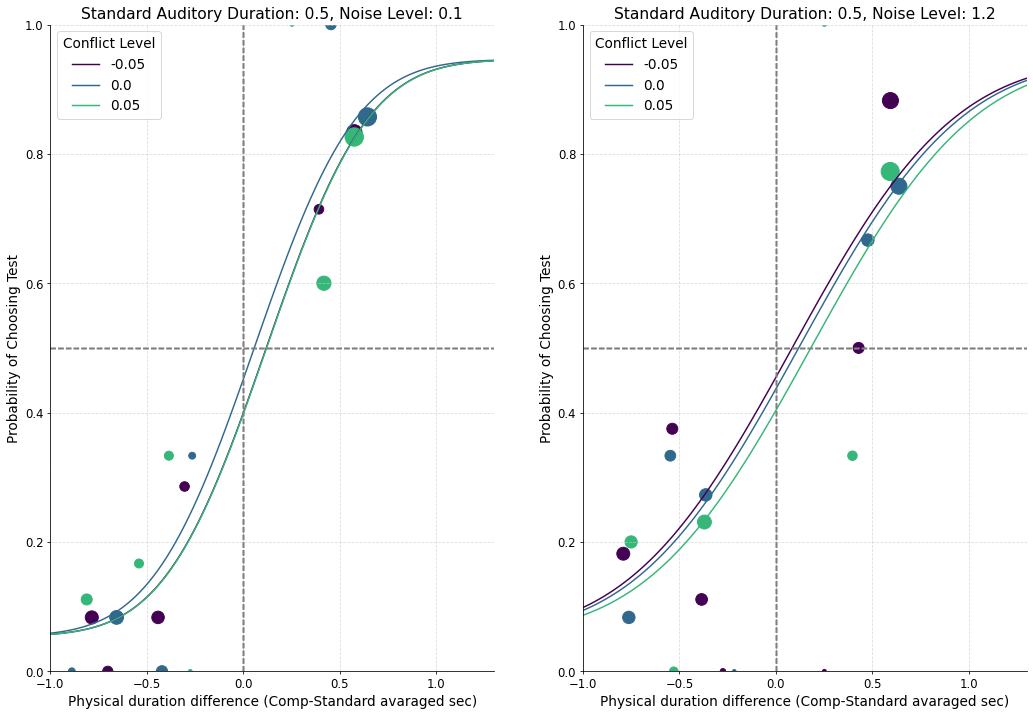

In [160]:
plt.figure(figsize=(fig_w*3,fig_h*2))
#plt.Subplot(3,2)

# take over all trials psychometric curve to compute the lapse rate on experiment
grouped=groupByChooseTest(data)
levels=grouped[intensityVariable].values
responses=grouped['num_of_chose_test'].values
totalResponses=grouped['total_responses'].values
# estimate init ial guesses
initial_guesses = estimate_initial_guesses(levels, responses, totalResponses)
# fit psychometric function
fitted_params = fit_psychometric_function(levels, responses, totalResponses, initial_guesses)
fixedLapse=fitted_params[0]  # use fitted lapse rate
print(f"Lapse rate over all trials: {fitted_params[0]:.2f}")

m=0
for i, standardLevel in enumerate(standardDurLevels):
    for j, noiseLevel in enumerate(noiseLevels):
        m+=1        
        df= data[data["standardDur"]==standardLevel]
        df=df[df["riseDur"]==noiseLevel]
        grouped=groupByChooseTest(df)
        # p_choose_test
        levels=grouped[intensityVariable].values
        responses=grouped['num_of_chose_test'].values
        totalResponses=grouped['total_responses'].values
        # estimate initial guesses
        initial_guesses = estimate_initial_guesses(levels, responses, totalResponses)
        # fit psychometric function
        fitted_params = fit_psychometric_function(levels, responses, totalResponses,initial_guesses,fixedLapse=fixedLapse)
        # print fitted parameters
        print(f"Standard duration: {standardLevel}, Noise level: {noiseLevel}, Fitted parameters: {fitted_params}")

        fixedSigma=fitted_params[1]  # use fitted sigma as fixed
        print(f"Sigma over noise level of {noiseLevel} trials: {fixedSigma:.2f}")


        for k, conflictLevel in enumerate(conflictLeves):
            #filter data
            df=data[data['conflictDur']==conflictLevel]
            df= df[df["standardDur"]==standardLevel]
            df=df[df["riseDur"]==noiseLevel]
            grouped=groupByChooseTest(df)
            # select levels
            levels=grouped[intensityVariable].values
            responses=grouped['num_of_chose_test'].values
            totalResponses=grouped['total_responses'].values
            #fixate the sigma and lapse rate and fit for mu
            # fit psychometric function
            fittedMu = fit_psychometric_function(levels, responses, totalResponses,initial_guesses,fixedLapse=fixedLapse, fixedSigma=fixedSigma)
            # print fitted parameters
            print(f"Conflict level: {conflictLevel}, Fitted parameters: {fittedMu}")
            # plot psychometric function
            #plt.scatter(levels, responses/totalResponses, label='Data', color='blue')
            plt.subplot(1,2,m)
            maxX = max(levels) if len(levels) > 0 else 1.3  # Handle case with no levels
            if maxX < 1.3:
                maxX = 1.3
            plt.xlim(-1, maxX)
            plt.ylim(0, 1)
            x = np.linspace(-1, maxX, 100)
            y = psychometric_function(x, fixedLapse, fittedMu, fixedSigma)  # use fixed sigma
            color=sns.color_palette("viridis", as_cmap=True)(k / len(conflictLeves))  # Use a colormap for different conflict levels
            plt.plot(x, y, label=round(conflictLevel, 2), color=color)
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel('Physical duration difference (Comp-Standard avaraged sec)')
            plt.ylabel('Probability of Choosing Test')
            plt.title(f'Standard Auditory Duration: {round(standardLevel,2)}, Noise Level: {round(noiseLevel,2)}')
            # add fitted parameters to the plot
            # plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
            #          bbox=dict(facecolor='white', alpha=0.5))
            plt.legend(title="Conflict Level", fontsize=14, title_fontsize=14)
            bin_and_plot(grouped, bin_method='cut', bins=8, plot=True,color=color)
            


# Wholesome Psychometric Function fitting

TypeError: estimate_initial_guesses() missing 2 required positional arguments: 'chooseTest' and 'totalResp'

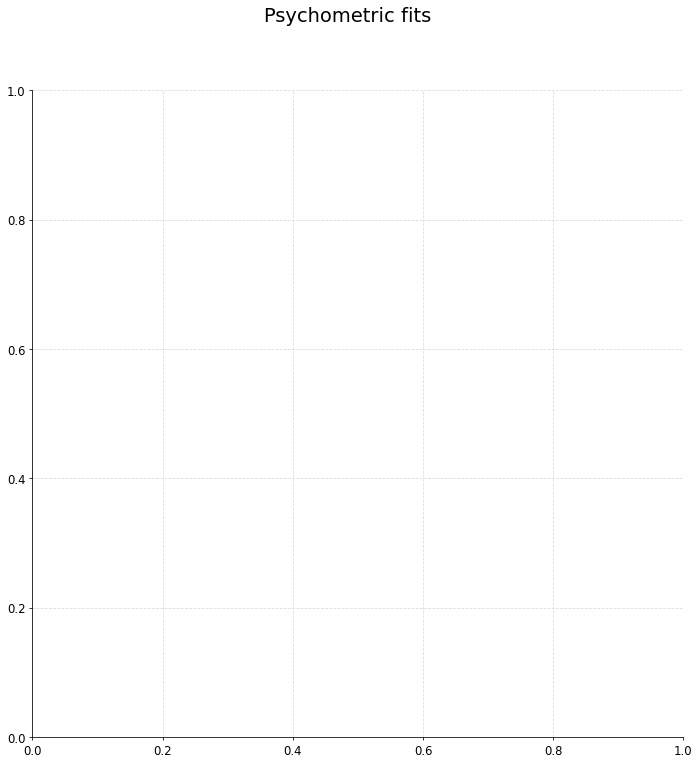

In [ ]:
from random import seed
import random
from scipy.stats import binned_statistic

seed(10)
# Generate a random hex color code
def random_hex_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))
# Control color generation within a specific range (e.g., for pastel colors)
def random_pastel_color():
    return (random.uniform(0.6, 1), random.uniform(0.6, 1), random.uniform(0.6, 1))
# Generate a random RGB tuple (values between 0 and 1)
def random_rgb_color():
    return (random.random(), random.random(), random.random())


def plot_psychometric_functions(data):
    fig, axs = plt.subplots(1,1, figsize=(12, 12))
    fig.suptitle('Psychometric fits', fontsize=20)

    #sort the data by standard duration
    data = data.sort_values(by='standard_dur')
    # fildering loop for each standard duration
    for k, i in enumerate(data['standard_dur'].unique()):
        # Filter data by standard duration
        data_by_standard = data[data['standard_dur'] == i].copy()

        # Group data by avgAVDelta and riseDur
        aggregated_data = data_by_standard.groupby(['avgAVDelta', 'riseDur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
        # Calculate the probability of choosing the test
        aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']
        # sort the values
        aggregated_data = aggregated_data.sort_values(by='riseDur')
        # select each riseDur and fit the psychometric function
        for j in aggregated_data['riseDur'].unique():
            #lineStyle = '--' if j == 0.80 else '-'  # Different line style for riseDur=0.050
            #lineColor = 'darkgreen' if j == 4.5 else 'orange'  # Different line color for riseDur=0.050
            lineColor=random_rgb_color()
            # Filter the data by riseDur
            X = aggregated_data[aggregated_data['riseDur'] == j]
   
            params_init = estimate_initial_guesses(X)
            # if np.abs(params_init[1])>0.5:
            #     params_init[1]=0

            print(f'Standard  of {i}s, Rise of {j}s')
            print(f"Initial guesses: {params_init[0]:.3f}, {params_init[1]:.3f}, {params_init[2]:.3f}")
            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(X,init_guesses=params_init) # Fit psychometric function

            print(f"Fitted parameters λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = X['avgAVDelta']
            y_data = X['p_choose_test']
                        
            # # Normalize bin sizes for scatter plot
            #ax = axs[k // 2, k % 2]
            X=X.sort_values(by='avgAVDelta')
            # bin_size=10
            # bin_distance=0.3
            # x_data=X['avgAVDelta']
            # y_data=X['p_choose_test']
            total_bins=X['total_responses']

            # for m in np.linspace(min(X['avgAVDelta']),max(X['avgAVDelta']),bin_size):
            #         # search for values +- 0.2 of the i value
            #         mask=(x_data>=m-bin_distance) & (x_data<m+bin_distance)
            #         # get the mean of the values
            #         x_mean=np.mean(x_data[mask])
            #         y_mean=np.mean(y_data[mask])
            #         # get the total responses
            #         total_resp=np.sum(total_bins[mask])
            #         # plot the mean values
            #         plt.plot(x_mean,y_mean,'o',markersize=((total_resp/np.sum(total_bins)+0.3)*20),color=lineColor)
            
            #Binning using pd.Cut 
            bin_size = 8  # Number of bins
            # Create bins
            X['bin'] = pd.cut(X['avgAVDelta'], bins=bin_size, labels=False, retbins=False, include_lowest=True)
            # Calculate means and sums within each bin
            bin_group = X.groupby('bin').agg(
                x_mean=('avgAVDelta', 'mean'),
                y_mean=('p_choose_test', 'mean'),
                total_resp=('total_responses', 'sum') )
            
            # Total responses for normalization of marker size
            total_responses = X['total_responses'].sum()
            # Plotting
            for index, row in bin_group.iterrows():
                marker_size = (row['total_resp'] / total_responses +0.5) * 20
                plt.plot(row['x_mean'], row['y_mean'],'o',markersize=marker_size,color=lineColor)
            

            # # binning using np.histogram
            # bin_size=6
            # bin_edges = [-0.8 -0.5,-0.3 -0.1, 0, 0.1, 0.3, 0.5, 0.8]

            # hist, bin_edges = np.histogram(X['avgAVDelta'], bins=bin_edges)    
            # bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            # # Calculate the mean of y_data for each bin
            # y_means = [np.mean(y_data[(x_data >= bin_edges[i]) & (x_data < bin_edges[i + 1])]) for i in range(len(bin_edges) - 1)]
            # # Calculate the total responses for each bin
            # total_bins = [np.sum(total_bins[(x_data >= bin_edges[i]) & (x_data < bin_edges[i + 1])]) for i in range(len(bin_edges) - 1)]
            # # Normalize the marker size
            # total_responses = np.sum(total_bins)
            # for i in range(len(bin_centers)):
            #     marker_size = (total_bins[i] / total_responses + 0.5) * 20
            #     plt.plot(bin_centers[i], y_means[i],'o',markersize=marker_size,color=lineColor) 
                           
            # Plot the psychometric function
            x_fit = np.linspace(min(X['avgAVDelta']),max(X['avgAVDelta']), 1000)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            plt.plot(x_fit, y_fit, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}', alpha=0.9,color=lineColor)
                     #linestyle=lineStyle, color=lineColor,)
            # scatter raw data
            plt.scatter(x_data, y_data, s=X['total_responses']*30, color=lineColor, alpha=0.2)
            plt.vlines(x=0, ymin=0, ymax=1, linestyles='dashed', colors='gray',alpha=0.5)   
            plt.hlines(y=0.5, xmin=min(X['avgAVDelta']), xmax=max(X['avgAVDelta']), linestyles='dashed', colors='gray',alpha=0.5)
            plt.xlabel('Delta duration percent (% of standard)')
            plt.ylabel('P(chose test)')
            plt.title(f'Test longer for Standard of {i}s')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
    plt.tight_layout()
    plt.show()

# Call the function
plot_psychometric_functions(data)
# Psychometric function fits when the data is pooled across all standard durations 